In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
import trackml
from trackml.dataset import load_event, load_dataset
from trackml.randomize import shuffle_hits
from trackml.score import score_event

from tqdm import tqdm

In [3]:
detector = pd.read_csv('../data/detectors.csv')
# method to retrieve the according module associated to a hit
def retrieve_module(detector,hit) :
    volume = detector[ detector['volume_id']==hit.volume_id.data[0] ]
    layer  = volume[ volume['layer_id']==hit.layer_id.data[0] ]
    module = layer[ layer['module_id']== hit.module_id.data[0] ]
    return module

def retrieve_module1(detector,hit) :
    volume = detector[ detector['volume_id']==hit.volume_id ]
    layer  = volume[ volume['layer_id']==hit.layer_id ]
    module = layer[ layer['module_id']== hit.module_id ]
    return module

In [4]:
# method to build and nomralize direction vector from the 
def direction_vector(ipx, ipy, ipz) :
    # the absolute momentum for normalization
    p = np.sqrt(ipx*ipx+ipy*ipy+ipz*ipz)
    # build the direction vector - to be used with the matrix 
    direction = [[ipx/p], [ipy/p], [ipz/p]]
    return direction


In [34]:
detectors = pd.read_csv('../data/detectors.csv')
# extract phi and theta from a direciton vector
def phi_theta(dx,dy,dz) :
    dr  = np.sqrt(dx*dx+dy*dy)
    phi = np.arctan2(dy,dx)
    theta = np.arctan2(dr,dz)
    return phi, theta

# function to extract the rotation matrix (and its inverse) from module dataframe
def extract_rotation_matrix(module) :
    rot_matrix = np.matrix( [[ module.rot_xu.data[0], module.rot_xv.data[0], module.rot_xw.data[0]],
                            [  module.rot_yu.data[0], module.rot_yv.data[0], module.rot_yw.data[0]],
                            [  module.rot_zu.data[0], module.rot_zv.data[0], module.rot_zw.data[0]]])
    return rot_matrix, np.linalg.inv(rot_matrix)

def extract_rotation_matrix1(module) :
    rot_matrix = np.matrix( [[ module.rot_xu.data[0], module.rot_xv.data[0], module.rot_xw.data[0]],
                            [  module.rot_yu.data[0], module.rot_yv.data[0], module.rot_yw.data[0]],
                            [  module.rot_zu.data[0], module.rot_zv.data[0], module.rot_zw.data[0]]])
    return rot_matrix, np.linalg.inv(rot_matrix)

def add_p_phi_theta_truth(h, truth):
    truth = truth.apply(abs)
    truth['tpr'] = np.sqrt(truth.tpx ** 2 + truth.tpy ** 2)
    truth['p_phi_truth'] = np.arctan2(truth.tpy, truth.tpx)
    truth['p_theta_truth'] = np.arctan2(truth.tpr, truth.tpz)
    return h.merge(truth[['hit_id', 'p_phi_truth', 'p_theta_truth']],
                   on='hit_id', how='left')

def add_cells(h, cells):
    h_clusters = cells.groupby('hit_id') \
                      .agg({'ch0': ['min', 'max'],
                            'ch1': ['min', 'max']}) \
                      .reset_index()
    h_clusters.columns = ['_'.join(column).strip('_')
                          for column in h_clusters.columns.values]
    return h.merge(h_clusters, on='hit_id', how='left')

def add_detectors(h, detectors):
    return h.merge(detectors,
                   on=['volume_id', 'layer_id', 'module_id'], how='left')

def add_p_phi_theta(h):
    h['cluster_size_u_max'] = h.ch0_max - h.ch0_min + 1
    h['cluster_size_u_min'] = h.cluster_size_u_max - 2
    h.loc[h.cluster_size_u_min < 0, 'cluster_size_u_min'] = 0

    h['cluster_size_v_max'] = h.ch1_max - h.ch1_min + 1
    h['cluster_size_v_min'] = h.cluster_size_v_max - 2
    h.loc[h.cluster_size_v_min < 0, 'cluster_size_v_min'] = 0

    h['pu_max'] = h.cluster_size_u_max * h.pitch_u
    h['pu_min'] = h.cluster_size_u_min * h.pitch_u

    h['pv_max'] = h.cluster_size_v_max * h.pitch_v
    h['pv_min'] = h.cluster_size_v_min * h.pitch_v

    h['pw'] = 2 * h.module_t

    h['angle_u_max'] = np.arctan2(h.pu_max, h.pw)
    h['angle_u_min'] = np.arctan2(h.pu_min, h.pw)
    h['angle_u_avg'] = 0.5 * (h.angle_u_max + h.angle_u_min)
    h['pu'] = h.pw * np.tan(h.angle_u_avg)

    h['angle_v_max'] = np.arctan2(h.pv_max, h.pw)
    h['angle_v_min'] = np.arctan2(h.pv_min, h.pw)
    h['angle_v_avg'] = 0.5 * (h.angle_v_max + h.angle_v_min)
    h['pv'] = h.pw * np.tan(h.angle_v_avg)

    h['px'] = abs(h.rot_xu * h.pu + h.rot_xv * h.pv + h.rot_xw * h.pw)
    h['py'] = abs(h.rot_yu * h.pu + h.rot_yv * h.pv + h.rot_yw * h.pw)
    h['pz'] = abs(h.rot_zu * h.pu + h.rot_zv * h.pv + h.rot_zw * h.pw)
    h['pr'] = np.sqrt(h.px ** 2 + h.py ** 2)
    h['p_phi'] = np.arctan2(h.py, h.px)
    h['p_theta'] = np.arctan2(h.pr, h.pz)


In [21]:
# One event of 8850
event_id = 'event000001038'
# "All methods either take or return pandas.DataFrame objects"
hits, cells, particles, truth = load_event('../data/train/'+event_id)


In [8]:
truth = pd.merge(truth, particles, how='left', on='particle_id')
hits = pd.merge(hits, truth, how='left', on='hit_id')

In [5]:
hits.tail(20)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,tpz,weight,vx,vy,vz,px,py,pz,q,nhits
113855,113856,-878.867004,491.279999,2955.5,18,12,92,0,-877.296997,490.588013,...,963306.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113856,113857,-790.231995,435.381012,2955.5,18,12,92,711568947282968576,-793.604980,436.981995,...,1.699150,0.000008,0.007499,0.012048,-3.049640,-0.525780,0.040264,1.713760,1.0,13.0
113857,113858,-835.885010,338.365997,2955.5,18,12,92,18017353446981632,-837.401978,339.054993,...,3.182740,0.000014,0.010171,0.005970,-3.820480,-0.811281,0.565867,3.177940,-1.0,13.0
113858,113859,-836.273010,338.812012,2944.5,18,12,93,18017353446981632,-834.299988,338.149994,...,3.183860,0.000010,0.010171,0.005970,-3.820480,-0.811281,0.565867,3.177940,-1.0,13.0
113859,113860,-749.762024,302.476013,2944.5,18,12,93,680056394275094528,-750.057983,302.598999,...,1.834310,0.000007,-0.010444,0.046432,0.589410,-0.374803,0.371251,1.828320,-1.0,14.0
113860,113861,-722.952026,219.684006,2944.5,18,12,93,148628889483100162,-726.619019,220.968994,...,0.577625,0.000009,-16.875601,-8.730160,85.456100,-0.106698,-0.143094,0.581317,1.0,11.0
113861,113862,-797.312988,291.813995,2944.5,18,12,93,0,-796.193970,291.416992,...,930261.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113862,113863,-836.658997,338.782990,2952.5,18,12,94,18017353446981632,-836.557007,338.808014,...,3.182810,0.000012,0.010171,0.005970,-3.820480,-0.811281,0.565867,3.177940,-1.0,13.0
113863,113864,-879.310974,308.480011,2952.5,18,12,94,36030033969545216,-876.236023,307.480011,...,3.494800,0.000017,-0.000111,0.013300,-8.518970,-1.090450,0.143190,3.511650,1.0,11.0
113864,113865,-838.228027,232.990005,2952.5,18,12,94,0,-837.119995,232.639999,...,680207.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# pick hit_id == 113871
h_id = 113871

In [7]:
pixel_cluster = cells[ cells['hit_id']==h_id ]

In [8]:
# a function that calculates the cluster size and makes a pixel matrix
def pixel_matrix(pixel_cluster, show=False):
    # cluster size
    min0 = min(pixel_cluster['ch0'])
    max0 = max(pixel_cluster['ch0'])
    min1 = min(pixel_cluster['ch1'])
    max1 = max(pixel_cluster['ch1'])
    # the matrix
    matrix = np.zeros(((max1-min1+3),(max0-min0+3)))
    for pixel in pixel_cluster.values :
        i0 = int(pixel[1]-min0+1)
        i1 = int(pixel[2]-min1+1)
        value = pixel[3]
        matrix[i1][i0] = value 
    # return the matris
    if show :
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.set_aspect('equal')
        plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.YlOrRd)
        plt.colorbar()
        plt.show()
    return matrix, max0-min0+1, max1-min1+1

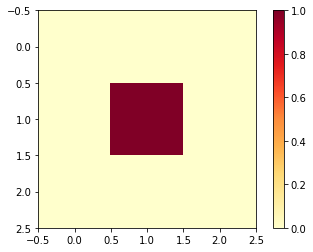

In [9]:
cluster,width,length = pixel_matrix(pixel_cluster,True)

In [10]:
width

1

In [11]:
length

1

In [12]:
cluster

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [13]:
# pick hit_id == 113872
h_id = 113873

In [14]:
pixel_cluster = cells[ cells['hit_id']==h_id ]

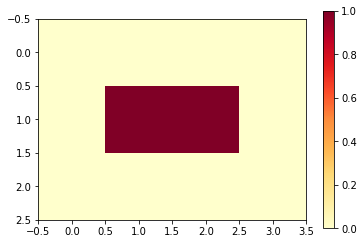

In [15]:
cluster,width,length = pixel_matrix(pixel_cluster,True)

In [16]:
width

2

In [17]:
length

1

In [18]:
# pick hit_id == 113856
h_id = 113856

In [19]:
pixel_cluster = cells[ cells['hit_id']==h_id ]

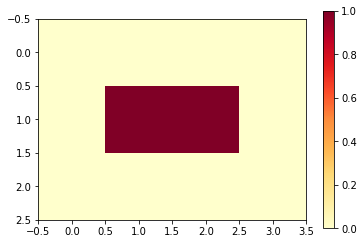

In [20]:
cluster,width,length = pixel_matrix(pixel_cluster,True)

In [21]:
width

2

In [22]:
length

1

In [67]:
h_id = 101

In [68]:
pixel_cluster = cells[ cells['hit_id']==h_id ]

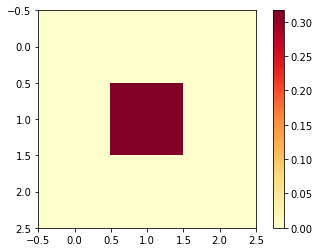

In [69]:
cluster,width,length = pixel_matrix(pixel_cluster,True)

In [70]:
width

1

In [71]:
length

1

In [72]:
cluster

array([[0.        , 0.        , 0.        ],
       [0.        , 0.31651899, 0.        ],
       [0.        , 0.        , 0.        ]])

In [29]:
for i, row in tqdm(hits.iterrows()):
#     if i > 0:
#         continue
#     print(row)
    h_id = row['hit_id']
    pixel_cluster = cells[ cells['hit_id']==h_id ]
    cluster,width,length = pixel_matrix(pixel_cluster,False)
    hits.loc[hits['hit_id'] == h_id, 'cells_width'] = width
    hits.loc[hits['hit_id'] == h_id, 'cells_length'] = length

113875it [10:48, 175.60it/s]


In [82]:
hits.head(1000)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vx,vy,vz,px,py,pz,q,nhits,cells_width,cells_length
0,1,-57.259499,-12.205200,-1502.5,7,2,1,504405632166658048,-57.254601,-12.185100,...,-0.005884,0.004838,7.634500,-0.711003,-0.169375,-18.863899,1.0,13.0,1.0,1.0
1,2,-69.977097,-13.356500,-1502.5,7,2,1,680069657134104576,-69.981102,-13.345800,...,-0.010444,0.046432,0.589410,-0.631954,-0.143298,-13.698400,1.0,14.0,1.0,1.0
2,3,-66.729301,-3.721990,-1502.5,7,2,1,171140634130776064,-66.749298,-3.737830,...,0.030384,0.000841,-3.319230,-0.169134,0.010716,-3.791640,-1.0,12.0,1.0,1.0
3,4,-64.853401,-12.501900,-1502.5,7,2,1,810648139085119488,-64.843597,-12.484800,...,-0.014898,0.013639,-4.368830,-1.157680,-0.244183,-26.833401,1.0,14.0,1.0,1.0
4,5,-62.312302,-8.740910,-1502.5,7,2,1,108088590080147456,-62.302601,-8.745710,...,0.007648,0.007087,2.509280,-0.317579,-0.062084,-7.768100,1.0,11.0,1.0,2.0
5,6,-76.812599,-11.737800,-1502.5,7,2,1,779125415594688512,-76.796898,-11.734800,...,0.029171,0.004402,-1.420120,-0.586405,-0.117376,-11.551200,1.0,14.0,1.0,2.0
6,7,-93.102600,-4.142520,-1502.5,7,2,1,779122872974049280,-93.094200,-4.156640,...,0.029171,0.004402,-1.420120,-0.216840,-0.035865,-3.555730,1.0,12.0,1.0,1.0
7,8,-90.385597,-12.856200,-1502.5,7,2,1,779124865838874624,-90.402000,-12.849900,...,0.029171,0.004402,-1.420120,-0.881019,-0.097400,-14.564300,-1.0,14.0,1.0,1.0
8,9,-65.613701,-5.948720,-1502.5,7,2,1,531427367369834496,-65.619301,-5.966230,...,-0.000692,0.002083,5.427480,-0.335370,-0.050483,-5.717390,1.0,13.0,2.0,2.0
9,10,-72.705498,-10.261000,-1502.5,7,2,1,707067958995714048,-72.725998,-10.246700,...,-0.000629,0.014336,6.068380,-0.397187,-0.032148,-8.154560,-1.0,14.0,1.0,2.0


In [31]:
hits_0 = hits[hits.particle_id == 0]

In [32]:
hits_0.shape

(17671, 25)

In [33]:
hits_0.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vx,vy,vz,px,py,pz,q,nhits,cells_width,cells_length
13,14,-43.534302,-0.666959,-1502.5,7,2,1,0,-43.533798,-0.667633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0
14,15,-88.923698,-14.226100,-1502.5,7,2,1,0,-88.915398,-14.222100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0
48,49,-71.281197,-21.509600,-1498.0,7,2,4,0,-71.274902,-21.516199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0
73,74,-120.015999,-31.300699,-1502.0,7,2,5,0,-120.015999,-31.301500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0
87,88,-78.032799,-33.943600,-1502.0,7,2,6,0,-78.034103,-33.943199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0


In [34]:
hits_0.cells_width.value_counts()

2.0     4306
3.0     3207
1.0     2976
4.0     2448
5.0     1978
6.0     1317
7.0      744
8.0      472
9.0      180
10.0      25
11.0       7
13.0       4
14.0       4
12.0       2
15.0       1
Name: cells_width, dtype: int64

In [35]:
hits_0.cells_length.value_counts()

1.0     10927
2.0      3101
3.0       938
4.0       688
5.0       439
6.0       240
7.0       149
8.0       113
9.0       113
10.0       91
11.0       79
13.0       61
12.0       57
14.0       54
17.0       48
15.0       45
16.0       36
19.0       35
18.0       31
22.0       28
21.0       28
23.0       25
20.0       25
30.0       21
26.0       20
24.0       20
31.0       19
25.0       18
28.0       18
29.0       15
27.0       15
32.0       15
38.0       13
34.0       13
35.0       13
40.0       12
33.0       11
41.0        9
51.0        8
44.0        8
49.0        7
36.0        7
37.0        7
46.0        6
50.0        6
53.0        5
48.0        5
42.0        5
43.0        5
54.0        5
47.0        4
45.0        4
52.0        3
39.0        3
Name: cells_length, dtype: int64

In [36]:
hits.cells_width.value_counts()

1.0     45052
2.0     26699
3.0     19155
4.0      9660
5.0      4786
6.0      3091
7.0      1856
8.0      1148
9.0       670
10.0      355
11.0      273
12.0      188
13.0      159
15.0      110
14.0      109
16.0       90
17.0       68
18.0       61
20.0       53
19.0       47
21.0       46
22.0       25
25.0       20
23.0       20
27.0       17
26.0       16
24.0       16
34.0        8
30.0        8
31.0        7
28.0        7
33.0        6
37.0        5
32.0        5
50.0        5
43.0        4
41.0        4
40.0        3
29.0        3
35.0        3
38.0        2
42.0        2
58.0        2
39.0        2
54.0        1
45.0        1
36.0        1
56.0        1
44.0        1
51.0        1
60.0        1
53.0        1
46.0        1
Name: cells_width, dtype: int64

In [37]:
hits.cells_length.value_counts()

1.0     59044
2.0     28170
3.0      3998
4.0      2450
5.0      2122
6.0      1652
7.0      1496
9.0      1234
8.0      1210
10.0     1054
11.0     1004
12.0      948
13.0      914
14.0      808
15.0      621
16.0      616
17.0      524
21.0      437
18.0      426
19.0      409
22.0      389
20.0      389
23.0      323
24.0      263
25.0      230
26.0      224
28.0      201
27.0      200
29.0      198
31.0      186
30.0      177
36.0      172
35.0      157
33.0      156
32.0      150
34.0      148
37.0      137
38.0      104
41.0       78
39.0       73
44.0       72
42.0       67
45.0       64
40.0       64
46.0       63
43.0       63
47.0       61
50.0       58
49.0       52
51.0       49
48.0       49
52.0       43
53.0       43
54.0       35
Name: cells_length, dtype: int64

In [107]:
h_id = 101
pixel_hit = hits[ hits['hit_id']==h_id ]
truth_pixel_hit = truth[ truth['hit_id']==h_id]
particle = particles[ particles['particle_id'] == truth_pixel_hit.particle_id.data[0] ]
print(particle)

             particle_id         vx       vy          vz        px        py  \
7365  603495750382399490 -18.323799 -5.02394 -256.916992 -0.162278 -0.074743   

           pz  q  nhits  
7365 -2.48855  1     13  


In [108]:
pixel_hit

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vx,vy,vz,px,py,pz,q,nhits,cells_width,cells_length
100,101,-104.681,-29.8911,-1498.0,7,2,7,603495750382399490,-104.690002,-29.871599,...,-18.323799,-5.02394,-256.916992,-0.162278,-0.074743,-2.48855,1.0,13.0,1.0,1.0


In [109]:
truth_pixel_hit

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,vx,vy,vz,px,py,pz,q,nhits
100,101,603495750382399490,-104.690002,-29.871599,-1498.0,-0.181785,-0.020635,-2.48345,0.000007,-18.323799,-5.02394,-256.916992,-0.162278,-0.074743,-2.48855,1.0,13.0


In [110]:
module = retrieve_module(detector,pixel_hit)

In [111]:
module

,volume_id,layer_id,module_id,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,...,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhu,module_maxhu,module_hv,pitch_u,pitch_v
6,7,2,7,-132.742,-44.4908,-1498.0,0.317791,-0.948161,0.0,-0.948161,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625


In [112]:
# get the truth direction at the module, it's more accurate than the starting position
direction_global_hit = direction_vector(truth_pixel_hit.tpx.data[0],
                                        truth_pixel_hit.tpy.data[0],truth_pixel_hit.tpz.data[0])
print(direction_global_hit)

[[-0.07300075530640754], [-0.008286510564819025], [-0.9972974598721052]]


In [113]:
direction_global_hit1 = direction_vector(pixel_hit.x.data[0],
                                        pixel_hit.y.data[0],pixel_hit.z.data[0])
print(direction_global_hit1)

[[-0.06969669981841049], [-0.019901520083958103], [-0.9973696905023584]]


In [114]:
# build the direction vector with the start momentum
direction_global_start = direction_vector(particle.px.data[0],particle.py.data[0],particle.pz.data[0])
print(direction_global_start)

[[-0.06504244862583636], [-0.029957730644709985], [-0.997432711640928]]


In [57]:
# get theta and phi
phi_hit, theta_hit = phi_theta(direction_global_hit[0][0],
                               direction_global_hit[1][0],
                               direction_global_hit[2][0])

In [58]:
print(phi_hit, theta_hit)

-3.0285637915186525 3.0680568352001205


In [59]:
# get theta and phi
phi_hit1, theta_hit1 = phi_theta(direction_global_hit1[0][0],
                               direction_global_hit1[1][0],
                               direction_global_hit1[2][0])

In [60]:
print(phi_hit1, theta_hit1)

-2.863449830276804 3.0690466213739764


In [61]:
# get the length of the cluster in v direction
cluster_length_v_hit = np.abs(2.*module.module_t.data[0]/np.tan(theta_hit))
cluster_size_v_hit   = cluster_length_v_hit/module.pitch_v.data[0]
print(cluster_length_v_hit,cluster_size_v_hit)

4.072288305985745 72.39623655085768


In [74]:
module_matrix, module_matrix_inv = extract_rotation_matrix(module)
print (module_matrix)

[[ 0.317791 -0.948161  0.      ]
 [-0.948161 -0.317791  0.      ]
 [ 0.        0.       -1.      ]]


In [75]:
direction_local_hit =  module_matrix_inv*direction_global_hit
print(direction_local_hit)

[[-0.01534203]
 [ 0.07184982]
 [ 0.99729746]]


In [76]:
direction_local_hit1 =  module_matrix_inv*direction_global_hit1
print(direction_local_hit1)

[[-0.00327914]
 [ 0.07240819]
 [ 0.99736969]]


In [77]:
# theta is defined as the arctan of the radial vs the longitudinal components
# phi is defined as the acran of the two transvese components
phi_local,theta_local = phi_theta(direction_local_hit[0][0],
                                  direction_local_hit[1][0],
                                  direction_local_hit[2][0])
print(phi_local,theta_local)

[[1.7811662]] [[0.0735358]]


In [78]:
# theta is defined as the arctan of the radial vs the longitudinal components
# phi is defined as the acran of the two transvese components
phi_local1,theta_local1 = phi_theta(direction_local_hit1[0][0],
                                  direction_local_hit1[1][0],
                                  direction_local_hit1[2][0])
print(phi_local1,theta_local1)

[[1.61605224]] [[0.07254602]]


In [79]:
path_in_silicon = 2*module.module_t.data[0]/np.cos(theta_local)
print(path_in_silicon)

[[0.30081296]]


In [80]:
# calculate the component in u and v
path_component_u = path_in_silicon*np.sin(theta_local)*np.cos(phi_local)
path_component_v = path_in_silicon*np.sin(theta_local)*np.sin(phi_local)
cluster_size_in_u = path_component_u/module.pitch_u.data[0]
cluster_size_in_v = path_component_v/module.pitch_v.data[0]
# print the cluster size 
print(cluster_size_in_u, cluster_size_in_v)

[[-0.09230163]] [[0.38423745]]


In [129]:
h_id = 113873
pixel_hit = hits[ hits['hit_id']==h_id ]
truth_pixel_hit = truth[ truth['hit_id']==h_id]
particle = particles[ particles['particle_id'] == truth_pixel_hit.particle_id.data[0] ]
print(particle)
print(pixel_hit)
print(truth_pixel_hit)
module = retrieve_module(detector,pixel_hit)
print(module)
# get the truth direction at the module, it's more accurate than the starting position
direction_global_hit = direction_vector(truth_pixel_hit.tpx.data[0],
                                        truth_pixel_hit.tpy.data[0],truth_pixel_hit.tpz.data[0])
print(direction_global_hit)
direction_global_hit1 = direction_vector(pixel_hit.x.data[0],
                                        pixel_hit.y.data[0],pixel_hit.z.data[0])
print(direction_global_hit1)
direction_global_hit2 = direction_vector(pixel_hit.tx.data[0],
                                        pixel_hit.ty.data[0],pixel_hit.tz.data[0])
print(direction_global_hit2)
# build the direction vector with the start momentum
direction_global_start = direction_vector(particle.px.data[0],particle.py.data[0],particle.pz.data[0])
print(direction_global_start)
# get theta and phi
phi_hit, theta_hit = phi_theta(direction_global_hit[0][0],
                               direction_global_hit[1][0],
                               direction_global_hit[2][0])
print(phi_hit, theta_hit)
phi_hit1, theta_hit1 = phi_theta(direction_global_hit1[0][0],
                               direction_global_hit1[1][0],
                               direction_global_hit1[2][0])
print(phi_hit1, theta_hit1)
phi_hit2, theta_hit2 = phi_theta(direction_global_hit2[0][0],
                               direction_global_hit2[1][0],
                               direction_global_hit2[2][0])
print(phi_hit2, theta_hit2)
# get the length of the cluster in v direction
cluster_length_v_hit = np.abs(2.*module.module_t.data[0]/np.tan(theta_hit))
cluster_size_v_hit   = cluster_length_v_hit/module.pitch_v.data[0]
print(cluster_length_v_hit,cluster_size_v_hit)
# get the length of the cluster in v direction
cluster_length_v_hit1 = np.abs(2.*module.module_t.data[0]/np.tan(theta_hit1))
cluster_size_v_hit1   = cluster_length_v_hit1/module.pitch_v.data[0]
print(cluster_length_v_hit1,cluster_size_v_hit1)
module_matrix, module_matrix_inv = extract_rotation_matrix(module)
print (module_matrix)
direction_local_hit =  module_matrix_inv*direction_global_hit
print(direction_local_hit)
direction_local_hit1 =  module_matrix_inv*direction_global_hit1
print(direction_local_hit1)
phi_local_hit1, theta_local_hit1 = phi_theta(direction_local_hit1[0][0],
                               direction_local_hit1[1][0],
                               direction_local_hit1[2][0])
print('phi_local1 = {}, theta_local1={}'.format(phi_local_hit1, theta_local_hit1))
path_in_silicon = 2*module.module_t.data[0]/np.cos(theta_local)
print(path_in_silicon)
path_in_silicon1 = 2*module.module_t.data[0]/np.cos(theta_local1)
print(path_in_silicon1)
# calculate the component in u and v
path_component_u = path_in_silicon*np.sin(theta_local)*np.cos(phi_local)
path_component_v = path_in_silicon*np.sin(theta_local)*np.sin(phi_local)
cluster_size_in_u = path_component_u/module.pitch_u.data[0]
cluster_size_in_v = path_component_v/module.pitch_v.data[0]
# print the cluster size 
print(cluster_size_in_u, cluster_size_in_v)

             particle_id       vx        vy        vz        px        py  \
3320  243205100116377600  0.01005 -0.037992  0.316311 -0.452502  0.201688   

           pz  q  nhits  
3320  1.74537 -1     13  
        hit_id           x        y       z  volume_id  layer_id  module_id  \
113872  113873 -798.711975 -3.08834  2944.5         18        12         97   

               particle_id         tx       ty      ...            vx  \
113872  243205100116377600 -801.97998 -2.87684      ...       0.01005   

              vy        vz        px        py       pz    q  nhits  \
113872 -0.037992  0.316311 -0.452502  0.201688  1.74537 -1.0   13.0   

        cells_width  cells_length  
113872          2.0           1.0  

[1 rows x 25 columns]
        hit_id         particle_id         tx       ty      tz       tpx  \
113872  113873  243205100116377600 -801.97998 -2.87684  2944.5 -0.434478   

             tpy     tpz    weight       vx        vy        vz        px  \
113872 -0.096846  1

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vx,vy,vz,px,py,pz,q,nhits,cells_width,cells_length
113872,113873,-798.711975,-3.08834,2944.5,18,12,97,243205100116377600,-801.97998,-2.87684,...,0.01005,-0.037992,0.316311,-0.452502,0.201688,1.74537,-1.0,13.0,2.0,1.0


In [128]:
h_id = 998
pixel_hit = hits[ hits['hit_id']==h_id ]
truth_pixel_hit = truth[ truth['hit_id']==h_id]
particle = particles[ particles['particle_id'] == truth_pixel_hit.particle_id.data[0] ]
print(particle)
print(pixel_hit)
print(truth_pixel_hit)
module = retrieve_module(detector,pixel_hit)
print('module='.format(module))
# get the truth direction at the module, it's more accurate than the starting position
direction_global_hit = direction_vector(truth_pixel_hit.tpx.data[0],
                                        truth_pixel_hit.tpy.data[0],truth_pixel_hit.tpz.data[0])
print(direction_global_hit)
direction_global_hit1 = direction_vector(pixel_hit.x.data[0],
                                        pixel_hit.y.data[0],pixel_hit.z.data[0])
print(direction_global_hit1)
direction_global_hit2 = direction_vector(pixel_hit.tx.data[0],
                                        pixel_hit.ty.data[0],pixel_hit.tz.data[0])
print(direction_global_hit2)
# build the direction vector with the start momentum
direction_global_start = direction_vector(particle.px.data[0],particle.py.data[0],particle.pz.data[0])
print(direction_global_start)
# get theta and phi
phi_hit, theta_hit = phi_theta(direction_global_hit[0][0],
                               direction_global_hit[1][0],
                               direction_global_hit[2][0])
print(phi_hit, theta_hit)
phi_hit1, theta_hit1 = phi_theta(direction_global_hit1[0][0],
                               direction_global_hit1[1][0],
                               direction_global_hit1[2][0])
print('phi1 = {}, theta1={}'.format(phi_hit1, theta_hit1))
phi_hit2, theta_hit2 = phi_theta(direction_global_hit2[0][0],
                               direction_global_hit2[1][0],
                               direction_global_hit2[2][0])
print(phi_hit2, theta_hit2)
# get the length of the cluster in v direction
cluster_length_v_hit = np.abs(2.*module.module_t.data[0]/np.tan(theta_hit))
cluster_size_v_hit   = cluster_length_v_hit/module.pitch_v.data[0]
print(cluster_length_v_hit,cluster_size_v_hit)
# get the length of the cluster in v direction
cluster_length_v_hit1 = np.abs(2.*module.module_t.data[0]/np.tan(theta_hit1))
cluster_size_v_hit1   = cluster_length_v_hit1/module.pitch_v.data[0]
print(cluster_length_v_hit1,cluster_size_v_hit1)
module_matrix, module_matrix_inv = extract_rotation_matrix(module)
print (module_matrix)
direction_local_hit =  module_matrix_inv*direction_global_hit
print(direction_local_hit)
direction_local_hit1 =  module_matrix_inv*direction_global_hit1
print(direction_local_hit1)
phi_local_hit1, theta_local_hit1 = phi_theta(direction_local_hit1[0][0],
                               direction_local_hit1[1][0],
                               direction_local_hit1[2][0])
print('phi_local1 = {}, theta_local1={}'.format(phi_local_hit1, theta_local_hit1))
path_in_silicon = 2*module.module_t.data[0]/np.cos(theta_local)
print(path_in_silicon)
path_in_silicon1 = 2*module.module_t.data[0]/np.cos(theta_local1)
print(path_in_silicon1)
# calculate the component in u and v
path_component_u = path_in_silicon*np.sin(theta_local)*np.cos(phi_local)
path_component_v = path_in_silicon*np.sin(theta_local)*np.sin(phi_local)
cluster_size_in_u = path_component_u/module.pitch_u.data[0]
cluster_size_in_v = path_component_v/module.pitch_v.data[0]
# print the cluster size 
print(cluster_size_in_u, cluster_size_in_v)

             particle_id        vx        vy       vz        px        py  \
7758  612508515897966592  0.004999 -0.014099  3.29164  0.242345  0.744801   

           pz  q  nhits  
7758 -10.4047  1     12  
     hit_id          x           y       z  volume_id  layer_id  module_id  \
997     998  39.824699  106.224998 -1502.0          7         2         75   

            particle_id         tx          ty      ...             vx  \
997  612508515897966592  39.812698  106.244003      ...       0.004999   

           vy       vz        px        py       pz    q  nhits  cells_width  \
997 -0.014099  3.29164  0.242345  0.744801 -10.4047  1.0   12.0          1.0   

     cells_length  
997           2.0  

[1 rows x 25 columns]
     hit_id         particle_id         tx          ty      tz       tpx  \
997     998  612508515897966592  39.812698  106.244003 -1502.0  0.302904   

          tpy      tpz    weight        vx        vy       vz        px  \
997  0.724067 -10.3981  0.000012  0

In [123]:
print(direction_global_hit1)

[[0.026439140972278966], [0.07052150428300671], [-0.9971598112932099]]


In [124]:
print(direction_local_hit1)

[[0.00429875]
 [0.07519196]
 [0.99715981]]


In [125]:
pixel_hit

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vx,vy,vz,px,py,pz,q,nhits,cells_width,cells_length
997,998,39.824699,106.224998,-1502.0,7,2,75,612508515897966592,39.812698,106.244003,...,0.004999,-0.014099,3.29164,0.242345,0.744801,-10.4047,1.0,12.0,1.0,2.0


In [48]:
for i, hit in tqdm(hits.iterrows()):

#     if i > 0:
#         continue
#     print(i)
#     print(hit)
    h_id = hit['hit_id']
    direction_global_hit = direction_vector(hit.x,hit.y,hit.z)
    phi_hit, theta_hit = phi_theta(direction_global_hit[0][0],
                               direction_global_hit[1][0],
                               direction_global_hit[2][0])

#     print(phi_hit,theta_hit)
    
    module = retrieve_module1(detector,hit)
#     print(module)
    module_matrix, module_matrix_inv = extract_rotation_matrix(module)
    direction_local_hit =  module_matrix_inv*direction_global_hit
  
    phi_local_hit, theta_local_hit = phi_theta(direction_local_hit[0][0],
                               direction_local_hit[1][0],
                               direction_local_hit[2][0])
#     print('phi_local1 = {}, theta_local1={}'.format(phi_local_hit1, theta_local_hit1))
    if (np.sign(phi_local_hit) == np.sign(theta_local_hit)):
        hits.loc[hits['hit_id'] == h_id, 'myq'] = 1
    else:
        hits.loc[hits['hit_id'] == h_id, 'myq'] = -1
        
    hits.loc[hits['hit_id'] == h_id, 'phi'] = phi_hit
    hits.loc[hits['hit_id'] == h_id, 'theta'] = theta_hit
    hits.loc[hits['hit_id'] == h_id, 'phi_local'] = phi_local_hit
    hits.loc[hits['hit_id'] == h_id, 'theta_local'] = theta_local_hit

113875it [25:44, 73.73it/s]


In [49]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,px,py,pz,q,nhits,phi,theta,myq,phi_local,theta_local
0,1,-57.259499,-12.20520,-1502.5,7,2,1,504405632166658048,-57.254601,-12.18510,...,-0.711003,-0.169375,-18.863899,1.0,13.0,-2.931580,3.102647,1.0,1.439323,0.038946
1,2,-69.977097,-13.35650,-1502.5,7,2,1,680069657134104576,-69.981102,-13.34580,...,-0.631954,-0.143298,-13.698400,1.0,14.0,-2.952992,3.094214,1.0,1.460735,0.047379
2,3,-66.729301,-3.72199,-1502.5,7,2,1,171140634130776064,-66.749298,-3.73783,...,-0.169134,0.010716,-3.791640,-1.0,12.0,-3.085873,3.097141,1.0,1.593616,0.044452
3,4,-64.853401,-12.50190,-1502.5,7,2,1,810648139085119488,-64.843597,-12.48480,...,-1.157680,-0.244183,-26.833401,1.0,14.0,-2.951157,3.097663,1.0,1.458900,0.043930
4,5,-62.312302,-8.74091,-1502.5,7,2,1,108088590080147456,-62.302601,-8.74571,...,-0.317579,-0.062084,-7.768100,1.0,11.0,-3.002226,3.099739,1.0,1.509970,0.041854


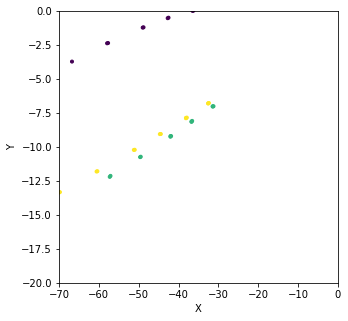

In [51]:
hits1 = hits[(hits.particle_id == 504405632166658048) | (hits.particle_id == 680069657134104576) |
            (hits.particle_id == 171140634130776064)]
fig = plt.figure(figsize=(5,5))
plt.scatter(hits1.x, hits1.y, marker='.',c=hits1.particle_id.values)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-70, 0)  
plt.ylim(-20, 0)
plt.show()

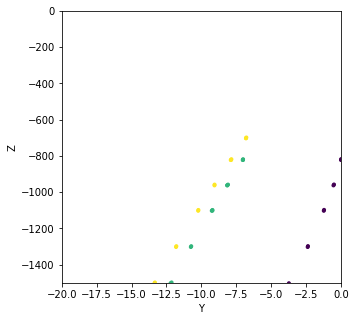

In [52]:
fig = plt.figure(figsize=(5,5))
plt.scatter(hits1.y, hits1.z, marker='.',c=hits1.particle_id.values)
plt.xlabel('Y')
plt.ylabel('Z')
plt.xlim(-20, 0)  
plt.ylim(-1500, 0)
plt.show()

In [53]:
hits1.shape

(39, 28)

In [55]:
hits1.sort_values(['particle_id','z'])[['hit_id', 'particle_id', 'phi_local', 'theta_local','q']]

,hit_id,particle_id,phi_local,theta_local,q
2,3,171140634130776064,1.593616,0.044452,-1.0
1465,1466,171140634130776064,1.608325,0.044477,-1.0
3141,3142,171140634130776064,1.451404,0.044456,-1.0
3185,3186,171140634130776064,1.624389,0.044418,-1.0
5209,5210,171140634130776064,1.467629,0.044430,-1.0
5273,5274,171140634130776064,1.636970,0.044357,-1.0
7629,7630,171140634130776064,1.480707,0.044373,-1.0
7737,7738,171140634130776064,1.649650,0.044345,-1.0
10478,10479,171140634130776064,1.492828,0.044337,-1.0
10582,10583,171140634130776064,1.658360,0.044327,-1.0


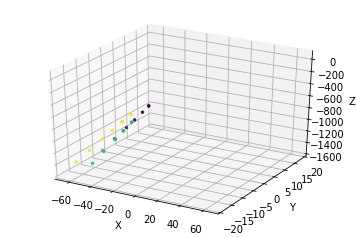

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hits1.x, hits1.y, hits1.z, marker='.', c=hits1.particle_id)
plt.xlim(-70, 70)  
plt.ylim(-20, 20)  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(-1600, 100)
plt.show()

In [64]:
 l = [[ 0,1,2],[ 1,0,2],[ 2,3,1],[ 3,2,1],[ 4,5,6],[ 5,6,7],[ 6,5,7],[ 7,8,9],[ 8,7,9],[ 9,10,8],
      [10,9,8],[11,0,1]]

In [67]:
np.bincount(np.array(l).ravel())

array([3, 5, 4, 2, 1, 3, 3, 4, 4, 4, 2, 1])

In [69]:
df = pd.DataFrame([[1,2],[3,4]], columns=['a','b'])

In [70]:
df

,a,b
0,1,2
1,3,4


In [73]:
df.iloc[0].a

1

In [8]:
cells.head()

,hit_id,ch0,ch1,value
0,1,321,498,0.312069
1,2,324,725,0.294907
2,3,137,654,0.271396
3,4,315,633,0.278624
4,5,244,582,0.075561


In [22]:
hits = add_cells(hits, cells)
hits = add_detectors(hits, detectors)
add_p_phi_theta(hits)

In [23]:
hits.head().T

,0,1,2,3,4
hit_id,1.000000,2.000000,3.000000,4.000000,5.000000
x,-57.259499,-69.977097,-66.729301,-64.853401,-62.312302
y,-12.205200,-13.356500,-3.721990,-12.501900,-8.740910
z,-1502.500000,-1502.500000,-1502.500000,-1502.500000,-1502.500000
volume_id,7.000000,7.000000,7.000000,7.000000,7.000000
layer_id,2.000000,2.000000,2.000000,2.000000,2.000000
module_id,1.000000,1.000000,1.000000,1.000000,1.000000
ch0_min,321.000000,324.000000,137.000000,315.000000,244.000000
ch0_max,321.000000,324.000000,137.000000,315.000000,244.000000
ch1_min,498.000000,725.000000,654.000000,633.000000,582.000000


In [26]:
# One event of 8850
event_id = 'event000001038'
# "All methods either take or return pandas.DataFrame objects"
hits1, cells, particles, truth = load_event('../data/train/'+event_id)
truth = pd.merge(truth, particles, how='left', on='particle_id')
hits1 = pd.merge(hits1, truth, how='left', on='hit_id')
hits1 = hits1.fillna(0)

In [27]:
hits1.head().T

,0,1,2,3,4
hit_id,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
x,-5.725950e+01,-6.997710e+01,-6.672930e+01,-6.485340e+01,-6.231230e+01
y,-1.220520e+01,-1.335650e+01,-3.721990e+00,-1.250190e+01,-8.740910e+00
z,-1.502500e+03,-1.502500e+03,-1.502500e+03,-1.502500e+03,-1.502500e+03
volume_id,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00
layer_id,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
module_id,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
particle_id,5.044056e+17,6.800697e+17,1.711406e+17,8.106481e+17,1.080886e+17
tx,-5.725460e+01,-6.998110e+01,-6.674930e+01,-6.484360e+01,-6.230260e+01
ty,-1.218510e+01,-1.334580e+01,-3.737830e+00,-1.248480e+01,-8.745710e+00


In [30]:
hits['particle_id'] = hits1.particle_id.values

In [32]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,ch0_min,ch0_max,ch1_min,ch1_max,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,rot_yv,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhu,module_maxhu,module_hv,pitch_u,pitch_v,cluster_size_u_max,cluster_size_u_min,cluster_size_v_max,cluster_size_v_min,pu_max,pu_min,pv_max,pv_min,pw,angle_u_max,angle_u_min,angle_u_avg,pu,angle_v_max,angle_v_min,angle_v_avg,pv,px,py,pz,pr,p_phi,p_theta,particle_id
0,1,-57.259499,-12.20520,-1502.5,7,2,1,321,321,498,498,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.0,0.05625,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.185348,0.0,0.092674,0.027882,0.025848,0.02694,0.3,0.037335,0.806077,0.123812,504405632166658048
1,2,-69.977097,-13.35650,-1502.5,7,2,1,324,324,725,725,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.0,0.05625,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.185348,0.0,0.092674,0.027882,0.025848,0.02694,0.3,0.037335,0.806077,0.123812,680069657134104576
2,3,-66.729301,-3.72199,-1502.5,7,2,1,137,137,654,654,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.0,0.05625,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.185348,0.0,0.092674,0.027882,0.025848,0.02694,0.3,0.037335,0.806077,0.123812,171140634130776064
3,4,-64.853401,-12.50190,-1502.5,7,2,1,315,315,633,633,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.0,0.05625,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.185348,0.0,0.092674,0.027882,0.025848,0.02694,0.3,0.037335,0.806077,0.123812,810648139085119488
4,5,-62.312302,-8.74091,-1502.5,7,2,1,244,244,582,583,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,2,0,0.05,0.0,0.11250,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.358771,0.0,0.179385,0.054400,0.052285,0.02902,0.3,0.059799,0.506710,0.196750,108088590080147456


In [35]:
hits[(hits.particle_id == 504405632166658048) | (hits.particle_id ==680069657134104576)]

,hit_id,x,y,z,volume_id,layer_id,module_id,ch0_min,ch0_max,ch1_min,ch1_max,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,rot_yv,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhu,module_maxhu,module_hv,pitch_u,pitch_v,cluster_size_u_max,cluster_size_u_min,cluster_size_v_max,cluster_size_v_min,pu_max,pu_min,pv_max,pv_min,pw,angle_u_max,angle_u_min,angle_u_avg,pu,angle_v_max,angle_v_min,angle_v_avg,pv,px,py,pz,pr,p_phi,p_theta,particle_id
0,1,-57.259499,-12.20520,-1502.5,7,2,1,321,321,498,498,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.0,0.05625,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.185348,0.0,0.092674,0.027882,0.025848,0.026940,0.3,0.037335,0.806077,0.123812,504405632166658048
1,2,-69.977097,-13.35650,-1502.5,7,2,1,324,324,725,725,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.0,0.05625,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.185348,0.0,0.092674,0.027882,0.025848,0.026940,0.3,0.037335,0.806077,0.123812,680069657134104576
43,44,-57.066399,-12.13210,-1498.0,7,2,4,137,137,503,503,-64.1764,-15.4074,-1498.0,0.233445,-0.972370,0.0,-0.972370,-0.233445,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.0,0.05625,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.185348,0.0,0.092674,0.027882,0.021316,0.030652,0.3,0.037335,0.963156,0.123812,504405632166658048
55,56,-69.758003,-13.32790,-1498.0,7,2,4,101,101,727,728,-64.1764,-15.4074,-1498.0,0.233445,-0.972370,0.0,-0.972370,-0.233445,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,2,0,0.05,0.0,0.11250,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.358771,0.0,0.179385,0.054400,0.047101,0.036842,0.3,0.059799,0.663789,0.196750,680069657134104576
1455,1456,-60.563000,-11.81310,-1302.5,7,4,1,308,308,556,556,-65.7965,-5.1783,-1302.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.0,0.05625,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.185348,0.0,0.092674,0.027882,0.025848,0.026940,0.3,0.037335,0.806077,0.123812,680069657134104576
1467,1468,-49.643700,-10.75310,-1302.5,7,4,1,304,304,361,361,-65.7965,-5.1783,-1302.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.0,0.05625,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.185348,0.0,0.092674,0.027882,0.025848,0.026940,0.3,0.037335,0.806077,0.123812,504405632166658048
1522,1523,-60.352699,-11.78980,-1298.0,7,4,4,115,115,558,559,-64.1764,-15.4074,-1298.0,0.233445,-0.972370,0.0,-0.972370,-0.233445,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,2,0,0.05,0.0,0.11250,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.358771,0.0,0.179385,0.054400,0.047101,0.036842,0.3,0.059799,0.663789,0.196750,680069657134104576
1524,1525,-49.479698,-10.72210,-1298.0,7,4,4,145,145,366,366,-64.1764,-15.4074,-1298.0,0.233445,-0.972370,0.0,-0.972370,-0.233445,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.0,0.05625,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.185348,0.0,0.092674,0.027882,0.021316,0.030652,0.3,0.037335,0.963156,0.123812,504405632166658048
3191,3192,-42.031799,-9.25130,-1102.5,7,6,1,286,286,224,224,-65.7965,-5.1783,-1102.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.0,0.05625,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.185348,0.0,0.092674,0.027882,0.025848,0.026940,0.3,0.037335,0.806077,0.123812,504405632166658048
3199,3200,-51.208801,-10.22430,-1102.5,7,6,1,291,291,388,388,-65.7965,-5.1783,-1102.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.0,0.05625,0.0,0.3,0.165149,0.0,0.082574,0.024829,0.185348,0.0,0.092674,0.027882,0.025848,0.026940,0.3,0.037335,0.806077,0.123812,680069657134104576
